## 7. Implement boosting and bagging with your choice of base models and explain all the steps 20

<p style="color:green;">Bagging is training multiple models (base learners) on different random subsets of the training data (with replacement). After training, the predictions of the individual models are averaged (for regression) or voted on (for classification) to get the final prediction.
</p>
<p style="color:green;"> Boosting is an ensemble technique where models (base learners) are trained sequentially. Each subsequent model attempts to correct the mistakes made by the previous models. It focuses on the harder examples that the earlier models misclassified.</p>

The text below can be added to the report md file:

We have implemented two ensemble learning methods, **Bagging** and **Boosting**.\
The **Bagging model** employs a `RandomForestClassifier` as its base estimator within a `BaggingClassifier`, where multiple decision trees are trained independently on random subsets of both samples and features.\
This parallel training reduces variance, prevents overfitting and improves model stability.\
The **Boosting model**, based on `XGBClassifier`, builds an ensemble of weak learners sequentially, where each new tree focuses on correcting the misclassifications made by previous ones.\
This reduced bias and improves predictive performance.

**Modified pipeline**\
The data is first split into training and testing sets using stratified sampling to preserve class distribution. Missing values are handled using a `SimpleImputer` with a median strategy.\
Next, a **`GridSearchCV`** is applied for hyperparameter tuning, testing combinations of parameters like the number of estimators, tree depth, learning rate, and subsampling ratios over multiple cross-validation folds.\
Finally, the best-performing model is refit on the training set and evaluated on the test data using accuracy metrics.\
Although computationally intensive, this approach provides a reliable comparison between Bagging and Boosting techniques.

In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [ ]:
### MODIFIED PIPELINE WITH BOOSTING AND BAGGING MODELS ###
df_my_train_data = pd.read_csv("./student-graduation/processed/train.csv")
df_my_test_data = pd.read_csv("./student-graduation/processed/test.csv")

# df_head = df_my_train_data.head(4000)
#df = df_head.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_train = df_my_train_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])
df_test = df_my_test_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_test['Target'] = le.fit_transform(df_test['Target'])

def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
        print('model = random_forest')
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [ 10.5, 11, 11.2, 10.8, 11.5],
            'model__kernel': ['linear','rbf','poly', 'sigmoid'],
            'model__gamma': ['scale', 'auto']
        }
        print('model = svm')
    elif model_type in ("neural_net", "mlp"):
        model = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.20,n_iter_no_change=20,early_stopping=True, solver='adam',     )
        param_grid = {
            'model__hidden_layer_sizes': [(64,), (128,128), (256)],
            'model__alpha': [1e-4, 1e-3, 1e-2],
            'model__learning_rate_init': [1e-3, 1e-2],
            'model__activation': ['relu', 'tanh']
        }
        print('model = neural_net')
    elif model_type in ("logistic", "logreg", "logistic_regression"):
        model = LogisticRegression(max_iter=2000)
        # Bruk liste av grids for å unngå inkompatible kombinasjoner av solver/penalty
        param_grid = [
            {   # LBFGS: bare L2
                'model__solver': ['lbfgs'],
                'model__penalty': ['l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # liblinear: L1/L2, ovr
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # saga: L1/L2, skalerer godt på større datasett
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            }
        ]
    elif model_type == "dt":
        model = DecisionTreeClassifier(random_state=42)
        param_grid = {
            'model__min_samples_leaf': [10, 20, 30],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
            'model__min_weight_fraction_leaf' :[0.0],
            "model__max_features": [None, "sqrt", "log2"],
            # "model__max_leaf_nodes": [63, 127],
            'model__min_samples_split':[2, 5, 7, 10],
            # splitter-strategi
            "model__splitter": ["best", "random"],
            # kostnad-kompleksitets-beskjæring
            "model__ccp_alpha": [0.0, 1e-3,],
            # håndter ev. ubalanse
            "model__class_weight": [None, "balanced"],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': [5, 10, 12, 15, 18],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
        }
        print("model = decision_tree")
    elif model_type in ("nb", "naive_bayes", "gaussian_nb"):
        model = GaussianNB()
        param_grid = {}  # har egentlig ingen viktige hyperparametre å tune
        print("model = gaussian_nb")
    
    # ---------------------------------------------------------
    # BAGGING MODELS
    # ---------------------------------------------------------
    elif model_type == "bagging_dt":
        base = DecisionTreeClassifier(random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
        print("model = bagging_dt")

    elif model_type == "bagging_svm":
        base = SVC(probability=True, random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 30],
            "model__max_samples": [0.6, 0.8],
            "model__max_features": [0.6, 0.8]
        }
        print("model = bagging_svm")

    elif model_type == "bagging_lr":
        base = LogisticRegression(max_iter=2000)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 20, 30],
            "model__max_samples": [0.5, 0.7, 1.0],
        }
        print("model = bagging_lr")


    # ---------------------------------------------------------
    # BOOSTING MODELS
    # ---------------------------------------------------------
    elif model_type == "adaboost_dt":
        base = DecisionTreeClassifier(max_depth=1)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.5, 1.0, 1.5]
        }
        print("model = adaboost_dt")

    elif model_type == "adaboost_lr":
        base = LogisticRegression(max_iter=2000)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [20, 50, 80],
            "model__learning_rate": [0.1, 0.5, 1.0]
        }
        print("model = adaboost_lr")


    elif model_type == "gradientboosting":
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1, 0.2],
            "model__max_depth": [2, 3, 4]
        }
        print("model = gradientboosting")


    elif model_type == "xgboost":
        model = XGBClassifier(
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )
        param_grid = {
            "model__n_estimators": [200, 300],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [4, 6, 8],
            "model__subsample": [0.6, 0.8, 1.0],
        }
        print("model = xgboost")

    else:
        raise ValueError("Ukjent modelltype")
    return model, param_grid

def run_pipeline(data_train: pd.DataFrame, data_test: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data_train.columns:
        raise ValueError(f"Målkolonnen '{target_column}' finnes ikke i data.")

    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[target_column]

    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[target_column]


    # Konservativ CV basert på minste klassefrekvens
    min_class_count = pd.Series(y_train).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )

    model, param_grid = get_model_and_params(model_type)

    
    if isinstance(model, MultinomialNB):
        steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', model)
        ]
    else:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False) if scipy.sparse.issparse(X_train) else StandardScaler()),
            ('model', model)
        ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Beste parametere:", grid_search.best_params_)
    print("📊 Test accuracy:", acc)
    return best_model

<h3 style="color:red"> WARNING: THE CODE BELOW TAKES A LONG TIME TO RUN</h3>

In [9]:
model_bagging_dt = run_pipeline(df_train, df_test, "Target", model_type="bagging_dt")
model_bagging_svm = run_pipeline(df_train, df_test, "Target", model_type="bagging_svm")
model_adaboost_dt = run_pipeline(df_train, df_test, "Target", model_type="adaboost_dt")
model_xgboost = run_pipeline(df_train, df_test, "Target", model_type="xgboost")

model = bagging_dt
✅ Beste parametere: {'model__max_features': 0.6, 'model__max_samples': 1.0, 'model__n_estimators': 200}
📊 Test accuracy: 0.7766726943942134
model = bagging_svm
✅ Beste parametere: {'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 30}
📊 Test accuracy: 0.7531645569620253
model = adaboost_dt
✅ Beste parametere: {'model__learning_rate': 1.5, 'model__n_estimators': 200}
📊 Test accuracy: 0.72875226039783
model = xgboost
✅ Beste parametere: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 300, 'model__subsample': 0.6}
📊 Test accuracy: 0.7694394213381555


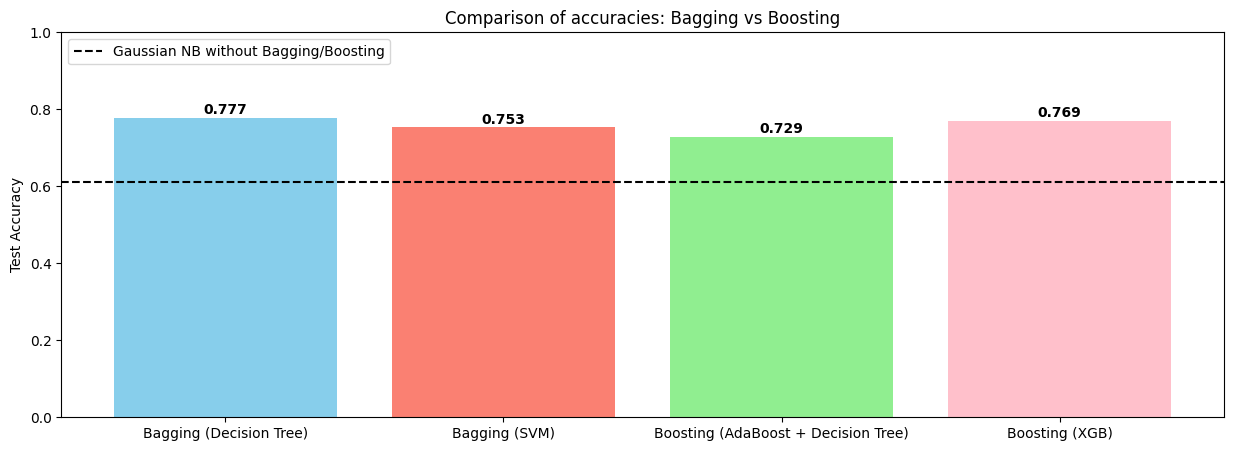

In [50]:
import matplotlib.pyplot as plt

# Store accuracies manually from pipeline
acc_bagging_dt = 0.7766726943942134 # replace as needed
acc_bagging_svm = 0.7531645569620253 # replace as needed
acc_adaboost_dt = 0.72875226039783 # replace as needed
acc_xgboost = 0.7694394213381555 # replace as needed
gaussian_nb_orginal_accurracy = 0.6103074141048824 # based on the value found in pipeline.ipynb, replace as needed

models = ['Bagging (Decision Tree)', 'Bagging (SVM)', 'Boosting (AdaBoost + Decision Tree)', 'Boosting (XGB)']
accuracies = [acc_bagging_dt, acc_bagging_svm, acc_adaboost_dt, acc_xgboost]

plt.figure(figsize=(15,5))
plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'pink'])
plt.axhline(y=gaussian_nb_orginal_accurracy, color='black', linestyle='--', label="Gaussian NB without Bagging/Boosting")
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of accuracies: Bagging vs Boosting")
plt.legend(loc="upper left")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

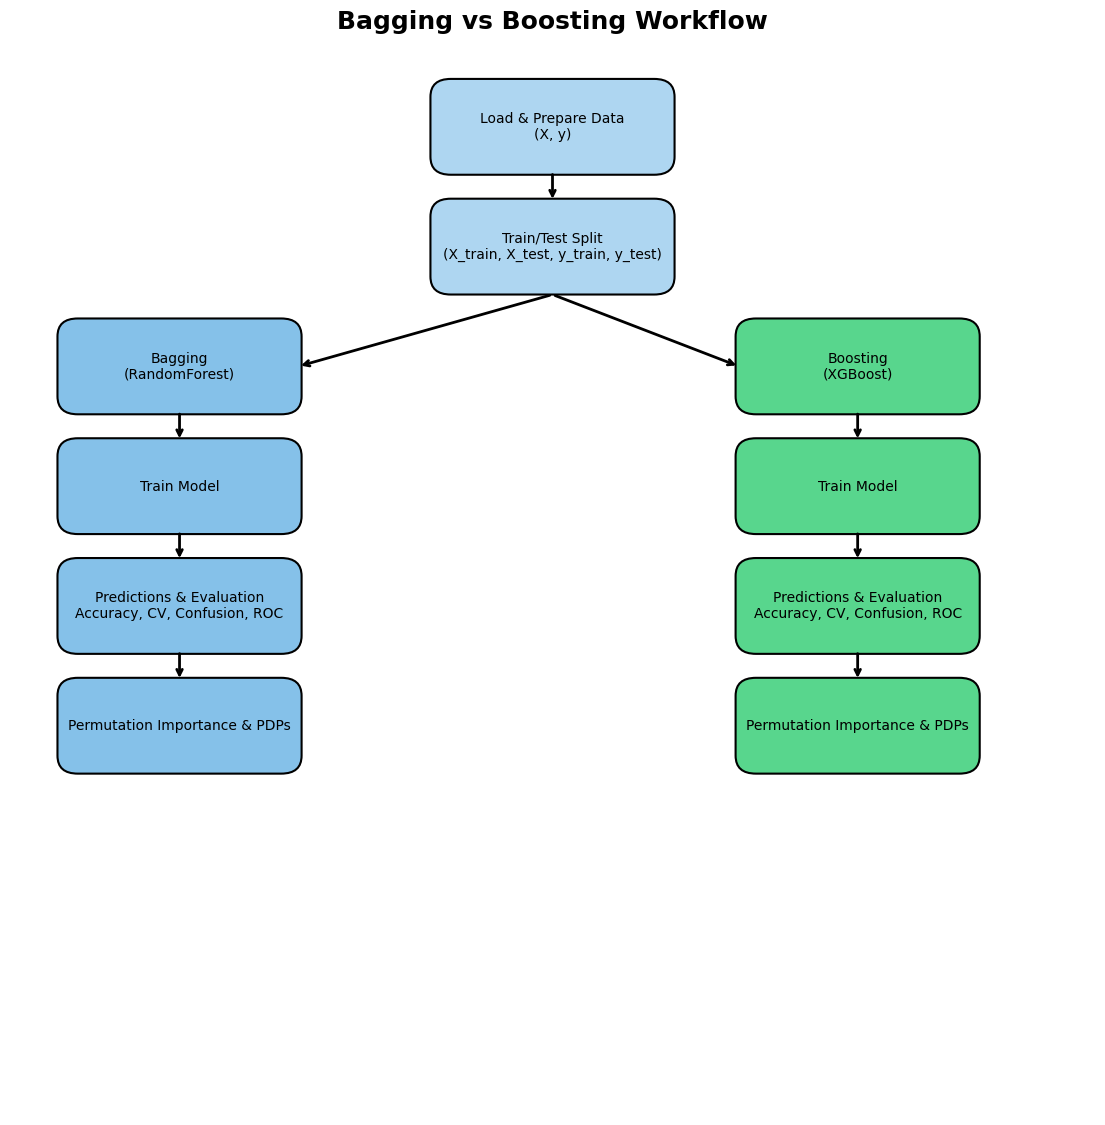

In [5]:
### EXPLANATION DIAGRAM ###
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(14, 14))
ax.axis('off')

def draw_box(text, xy, width=3, height=1, color='#AED6F1'):
    box = FancyBboxPatch(
        xy, width, height,
        boxstyle="round,pad=0.3",
        edgecolor='black',
        facecolor=color,
        linewidth=1.5
    )
    ax.add_patch(box)
    ax.text(xy[0]+width/2, xy[1]+height/2, text, ha='center', va='center', fontsize=10)

# Set plot limits
ax.set_xlim(0, 16)
ax.set_ylim(0, 18)

# Central Data boxes (top)
draw_box("Load & Prepare Data\n(X, y)", (6.5, 16))
draw_box("Train/Test Split\n(X_train, X_test, y_train, y_test)", (6.5, 14))

# Bagging branch (left) - blue
bag_color = '#85C1E9'
draw_box("Bagging\n(RandomForest)", (1, 12), color=bag_color)
draw_box("Train Model", (1, 10), color=bag_color)
draw_box("Predictions & Evaluation\nAccuracy, CV, Confusion, ROC", (1, 8), color=bag_color)
draw_box("Permutation Importance & PDPs", (1, 6), color=bag_color)

# Boosting branch (right) - green
boost_color = '#58D68D'
draw_box("Boosting\n(XGBoost)", (11, 12), color=boost_color)
draw_box("Train Model", (11, 10), color=boost_color)
draw_box("Predictions & Evaluation\nAccuracy, CV, Confusion, ROC", (11, 8), color=boost_color)
draw_box("Permutation Importance & PDPs", (11, 6), color=boost_color)

# Draw arrows
def draw_arrow(start, end):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=2))

# Central flow arrows
draw_arrow((8, 15.75), (8, 15.25))      # Data -> Split
draw_arrow((8, 13.7), (4.25, 12.5))    # Split -> Bagging
draw_arrow((8, 13.7), (10.75, 12.5))   # Split -> Boosting

# Bagging arrows
draw_arrow((2.5, 11.75), (2.5, 11.25))
draw_arrow((2.5, 9.75), (2.5, 9.25))
draw_arrow((2.5, 7.75), (2.5, 7.25))

# Boosting arrows
draw_arrow((12.5, 11.75), (12.5, 11.25))
draw_arrow((12.5, 9.75), (12.5, 9.25))
draw_arrow((12.5, 7.75), (12.5, 7.25))

plt.title("Bagging vs Boosting Workflow", fontsize=18, fontweight='bold')
plt.show()
